In [1]:
print("hi")

hi


In [2]:
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt; 

import importlib, tsp_data
importlib.reload(tsp_data)

from tsp_data import (
    TSPConfig, TSPDataset, get_tsp_loaders, 
    decode_coords, distance_matrix, tour_length_from_successors,
    plot_tsp_instance_from_tokens
)

# Configure a small, exact TSP to start
cfg = TSPConfig(
    n_cities=8,           # keep small for exact Held-Karp in Python
    grid_size=16,         # coordinates on a 16x16 integer grid
    solver="auto",        # exact up to max_exact_cities, else 2-opt
    max_exact_cities=12,
    seed=123
)

# Build loaders
train_loader, val_loader = get_tsp_loaders(
    n_train=2048,         # pick what you need
    n_val=512,
    batch_size=32,
    cfg=cfg
)

# Derive TRM dimensions
SEQ_LEN = cfg.n_cities
INPUT_TOKENS = cfg.grid_size * cfg.grid_size
OUTPUT_TOKENS = cfg.n_cities

# Quick sanity like Sudoku
bx, by = next(iter(train_loader))
assert bx.shape[1] == SEQ_LEN and by.shape[1] == SEQ_LEN
assert bx.min().item() >= 0 and bx.max().item() < INPUT_TOKENS
assert by.min().item() >= 0 and by.max().item() < OUTPUT_TOKENS
print("Sanity OK: x in [0, INPUT_TOKENS-1], y in [0, n_cities-1]")

# Inspect one validation example: decode, recompute tour length
x_tokens, y_tokens = next(iter(val_loader))
coords = decode_coords(x_tokens[0].numpy(), cfg.grid_size)  # [L, 2] integer coordinates
dist = distance_matrix(coords)                              # [L, L] float64 distances
length = tour_length_from_successors(dist, y_tokens[0].numpy())
print("Example tour length:", length)

# If you want to visualize the permutation:
print("Successor mapping:", y_tokens[0].tolist())


Sanity OK: x in [0, INPUT_TOKENS-1], y in [0, n_cities-1]
Example tour length: 46.3702322388002
Successor mapping: [1, 2, 5, 4, 7, 3, 0, 6]


In [3]:
# Verify the successor mapping really is a single cycle
from tsp_data import _is_single_cycle, decode_coords, distance_matrix, tour_length_from_successors
x_tokens, y_tokens = next(iter(val_loader))
coords = decode_coords(x_tokens[0].numpy(), cfg.grid_size)
assert _is_single_cycle(y_tokens[0].numpy())

# For very small n (<=10), optionally brute-force to confirm optimality
import itertools, numpy as np
if cfg.n_cities <= 10:
    dist = distance_matrix(coords)
    best = np.inf
    for perm in itertools.permutations(range(1, cfg.n_cities)):  # start fixed at 0
        cyc = (0,) + perm + (0,)
        cost = sum(dist[cyc[k], cyc[k+1]] for k in range(cfg.n_cities))
        if cost < best: best = cost
    hk_len = tour_length_from_successors(dist, y_tokens[0].numpy())
    print("Held-Karp length:", hk_len, "Brute-force length:", best)


Held-Karp length: 46.3702322388002 Brute-force length: 46.3702322388002


In [4]:
import exploretinyrm as m
print("exploretinyrm:", m.__version__)

%load_ext autoreload
%autoreload 2

import os, math, random, sys
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

# Make sure TRM is on path if your repo uses a local src/ layout
sys.path.append("src")

from exploretinyrm.trm import TRM, TRMConfig

# TSP data utilities you created
from tsp_data import (
    TSPConfig, get_tsp_loaders,
    decode_coords, distance_matrix, tour_length_from_successors,
    path_from_successors
)

def set_seed(seed: int = 123):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

exploretinyrm: 0.1.0
Device: cuda


In [5]:
# Mixed precision helpers (forward-compatible)
try:
    from torch.amp import autocast as _autocast, GradScaler as _GradScaler
    _USE_TORCH_AMP = True
except ImportError:
    from torch.cuda.amp import autocast as _autocast, GradScaler as _GradScaler
    _USE_TORCH_AMP = False

def make_grad_scaler(is_cuda: bool):
    if _USE_TORCH_AMP:
        try:
            return _GradScaler("cuda", enabled=is_cuda)
        except TypeError:
            return _GradScaler(enabled=is_cuda)
    else:
        return _GradScaler(enabled=is_cuda)

def amp_autocast(is_cuda: bool, use_amp: bool):
    if _USE_TORCH_AMP:
        try:
            return _autocast(device_type="cuda", enabled=(is_cuda and use_amp))
        except TypeError:
            return _autocast(enabled=(is_cuda and use_amp))
    else:
        return _autocast(enabled=(is_cuda and use_amp))

# EMA utility
class EMA:
    def __init__(self, model: torch.nn.Module, decay: float = 0.999):
        self.decay = decay
        self.shadow = {
            name: param.detach().clone()
            for name, param in model.named_parameters()
            if param.requires_grad
        }

    def update(self, model: torch.nn.Module) -> None:
        d = self.decay
        with torch.no_grad():
            for name, p in model.named_parameters():
                if not p.requires_grad:
                    continue
                self.shadow[name].mul_(d).add_(p.detach(), alpha=1.0 - d)

    def copy_to(self, model: torch.nn.Module) -> None:
        with torch.no_grad():
            for name, p in model.named_parameters():
                if name in self.shadow:
                    p.copy_(self.shadow[name])

from contextlib import contextmanager

@contextmanager
def use_ema_weights(model: torch.nn.Module, ema: EMA):
    backup = {
        name: p.detach().clone()
        for name, p in model.named_parameters()
        if p.requires_grad
    }
    ema.copy_to(model)
    try:
        yield
    finally:
        with torch.no_grad():
            for name, p in model.named_parameters():
                if name in backup:
                    p.copy_(backup[name])


In [6]:
# TRM hyperparameters sized for a 4 GB GPU
D_MODEL = 128
N_SUP   = 8      # number of supervision recursions per batch step
N       = 4      # number of z-updates per recursion
T       = 3      # number of deep recursions inside each supervision pass
K_LAST_OPS = None   # backprop only through the last K net calls inside final recursion

USE_ATT = True   # attention is helpful for TSP

cfg_trm = TRMConfig(
    input_vocab_size=INPUT_TOKENS,
    output_vocab_size=OUTPUT_TOKENS,
    seq_len=SEQ_LEN,
    d_model=D_MODEL,
    n_layers=2,
    use_attention=USE_ATT,
    n_heads=4,               # 128 % 4 == 0
    dropout=0.0,
    mlp_ratio=4.0,
    token_mlp_ratio=2.0,
    n=N,
    T=T,
    k_last_ops=K_LAST_OPS,
    stabilize_input_sums=True
)

model = TRM(cfg_trm).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.0, betas=(0.9, 0.95))
scaler = make_grad_scaler(device.type == "cuda")
ema = EMA(model, decay=0.999)


Params (M): 0.558976


In [7]:

# --- Path-based evaluation with coverage and cycle validity (5 metrics) ---

import numpy as np
import torch

def is_single_cycle(successor: np.ndarray) -> bool:
    n = len(successor)
    seen = np.zeros(n, dtype=bool)
    cur = 0
    for _ in range(n):
        if seen[cur]:
            return False
        seen[cur] = True
        cur = int(successor[cur])
    return cur == 0 and seen.all()

def tour_length_from_path(dist: np.ndarray, path: list[int]) -> float:
    return float(sum(dist[path[i], path[i+1]] for i in range(len(path) - 1)))

@torch.no_grad()
def evaluate(model: TRM, loader: DataLoader, n_sup_eval: int = N_SUP):
    model.eval()
    em_list, tok_acc_list = [], []
    cover_list, valid_list, gap_list = [], [], []

    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device)
        y_true   = y_true.to(device)

        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
        for _ in range(n_sup_eval):
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=K_LAST_OPS
            )

        L = logits.shape[1]
        ar = torch.arange(L, device=logits.device)
        logits_masked = logits.clone()
        logits_masked[:, ar, ar] = logits_masked[:, ar, ar] - 1e9
        preds = logits_masked.argmax(dim=-1)

        # classic metrics
        em = (preds == y_true).all(dim=1).float()
        tok_acc = (preds == y_true).float().mean(dim=1)
        em_list.append(em); tok_acc_list.append(tok_acc)

        # path-based metrics
        x_np = x_tokens.detach().cpu().numpy()
        y_np = y_true.detach().cpu().numpy()
        p_np = preds.detach().cpu().numpy()

        for i in range(x_np.shape[0]):
            coords = decode_coords(x_np[i], cfg_data.grid_size)
            dist = distance_matrix(coords)

            # Build explicit paths (0,...,0) and measure lengths along the explicit path
            gt_path = path_from_successors(y_np[i], start=0)
            pr_path = path_from_successors(p_np[i], start=0)
            gt_len  = tour_length_from_path(dist, gt_path)
            pr_len  = tour_length_from_path(dist, pr_path)

            coverage = len(set(pr_path[:-1])) / SEQ_LEN
            cover_list.append(coverage)
            valid = is_single_cycle(p_np[i])
            valid_list.append(1.0 if valid else 0.0)

            gap_list.append((pr_len - gt_len) if (coverage == 1.0 and valid) else np.nan)

    em = torch.cat(em_list).mean().item()
    tok_acc = torch.cat(tok_acc_list).mean().item()
    coverage = float(np.nanmean(cover_list)) if cover_list else 0.0
    valid_rate = float(np.nanmean(valid_list)) if valid_list else 0.0
    gap_valid = float(np.nanmean([g for g in gap_list if not np.isnan(g)])) if any(not np.isnan(g) for g in gap_list) else float('nan')

    print(f"Validation | EM {em:.3f} | Token {tok_acc:.3f} | Coverage {coverage:.3f} | ValidCycle {valid_rate:.3f} | AvgGap(valid) {gap_valid:.3f}")
    return em, tok_acc, coverage, valid_rate, gap_valid

@torch.no_grad()
def evaluate_with_ema(model: TRM, ema: EMA, loader: DataLoader, n_sup_eval: int = N_SUP):
    with use_ema_weights(model, ema):
        return evaluate(model, loader, n_sup_eval=n_sup_eval)




In [8]:
# Small, exact labels for a stable proof of concept
cfg_data = TSPConfig(
    n_cities=8,          # sequence length L
    grid_size=16,        # input vocab = 256
    solver="auto",       # exact up to max_exact_cities
    max_exact_cities=12,
    seed=123
)

# Dataloaders
train_loader, val_loader = get_tsp_loaders(
    n_train=2048,
    n_val=512,
    batch_size=32,       # bump up or down based on memory
    cfg=cfg_data
)

# Derive TRM dimensions
SEQ_LEN = cfg_data.n_cities
INPUT_TOKENS = cfg_data.grid_size * cfg_data.grid_size
OUTPUT_TOKENS = cfg_data.n_cities

# Sanity on one batch
bx, by = next(iter(train_loader))
assert bx.shape[1] == SEQ_LEN and by.shape[1] == SEQ_LEN
assert bx.min().item() >= 0 and bx.max().item() < INPUT_TOKENS
assert by.min().item() >= 0 and by.max().item() < OUTPUT_TOKENS
print("Sanity OK: x in [0, INPUT_TOKENS-1], y in [0, n_cities-1], seq_len =", SEQ_LEN)

Sanity OK: x in [0, INPUT_TOKENS-1], y in [0, n_cities-1], seq_len = 8


In [9]:
import math

def init_coord_embedding_(model: TRM, grid_size: int, d_model: int, seed: int = 0):
    rng = np.random.default_rng(seed)
    V = grid_size * grid_size

    W = np.zeros((V, d_model), dtype=np.float32)
    for t in range(V):
        x = t % grid_size
        y = t // grid_size
        # normalize to [-1, 1]
        xf = (x / (grid_size - 1)) * 2.0 - 1.0
        yf = (y / (grid_size - 1)) * 2.0 - 1.0
        r  = math.sqrt(xf*xf + yf*yf)
        th = math.atan2(yf, xf) / math.pi  # ~[-1, 1]

        # coordinate features (6 dims): x, y, xy, x^2, y^2, r, (optionally angle)
        feats = [xf, yf, xf*yf, xf*xf, yf*yf, r, th]
        k = len(feats)
        W[t, :k] = np.array(feats, dtype=np.float32)

    # small random for remaining channels
    if d_model > k:
        W[:, k:] = 0.02 * rng.standard_normal(size=(V, d_model - k)).astype(np.float32)

    with torch.no_grad():
        model.input_emb.weight.copy_(torch.from_numpy(W))

# call once after model creation
init_coord_embedding_(model, grid_size=cfg_data.grid_size, d_model=cfg_trm.d_model, seed=123)
print("Initialized input embedding with coordinate features.")


Initialized input embedding with coordinate features.


# TSP data TRM: quick start and reference

The dataset provides fixed‑length `(x_tokens, y_tokens)` pairs suitable for training the Tiny Recursion Model (TRM) on Traveling Salesman Problem (TSP) instances with a discrete 2D grid.

- Sequence length `L = n_cities`.
- Input vocabulary: integer coordinates on a `grid_size x grid_size` grid, flattened to a single token per city. `input_vocab_size = grid_size * grid_size`.
- Output vocabulary: successor city indices in the tour. `output_vocab_size = n_cities`.
- Label semantics: `y_tokens[j]` is the index of the next city after city `j` on a canonical optimal tour starting at city 0. Reverse duplicates are tie‑broken deterministically.
- TRM expects fixed [B, L] inputs and [B, L] outputs trained with token‑level cross entropy and a halting head supervised by exact‑match. This format follows that setup (see Section 2.1 of the TRM paper for the [B, L] task framing). :contentReference[oaicite:0]{index=0}

---

## 1) Install and import

Place `tsp_data.py` next to your notebook or in `src/`. Then:

```python
from tsp_data import (
    TSPConfig, TSPDataset, get_tsp_loaders,
    decode_coords, distance_matrix, tour_length_from_successors
)
```

---

## 2) Configure a run

Pick the number of cities and grid size. The solver is chosen automatically:
- Exact Held‑Karp for small `n_cities` (up to `max_exact_cities`, default 12).
- 2‑opt local search otherwise.

```python
cfg = TSPConfig(
    n_cities=10,        # sequence length L
    grid_size=16,       # tokens in {0..grid_size^2-1}
    solver="auto",      # "auto" | "held_karp" | "two_opt"
    max_exact_cities=12,
    seed=123
)

train_loader, val_loader = get_tsp_loaders(
    n_train=2048,
    n_val=512,
    batch_size=32,
    cfg=cfg
)

# Derive TRM dimensions
SEQ_LEN = cfg.n_cities
INPUT_TOKENS = cfg.grid_size * cfg.grid_size
output_vocab_size = cfg.n_cities
```

Notes:
- For proof‑of‑concept training, try `n_cities` in `[6, 12]` so you get exact optimal tours cheaply.
- For larger `n_cities`, switch to `"two_opt"` explicitly if you want speed.

---

## 3) What a batch looks like

Each batch yields integer tensors shaped `[B, L]`.

```python
x_tokens, y_tokens = next(iter(train_loader))
print(x_tokens.shape, y_tokens.shape)   # torch.Size([B, L]) torch.Size([B, L])

# Contracts
assert x_tokens.min().item() >= 0 and x_tokens.max().item() < INPUT_TOKENS
assert y_tokens.min().item() >= 0 and y_tokens.max().item() < output_vocab_size
```

Semantics:
- `x_tokens[j]` is the flattened coordinate token of city `j`.
- `y_tokens[j]` is the successor city index after `j` in the canonical tour.

---

## 4) Accessing coordinates and tour quality

You can decode integer coordinate tokens and compute distances and tour length to verify data or evaluate predictions.

```python
# Decode integer coordinates for one item
coords = decode_coords(x_tokens[0].cpu().numpy(), cfg.grid_size)  # shape [L, 2]

# Build Euclidean distance matrix
dist = distance_matrix(coords)  # shape [L, L], float64

# Ground truth tour length from the successor mapping
gt_len = tour_length_from_successors(dist, y_tokens[0].cpu().numpy())
print("Ground truth tour length:", gt_len)
```

To reconstruct the explicit path `[0, v1, ..., v_{L-1}, 0]` from successors:

```python
def path_from_successors(succ, start=0):
    n = len(succ)
    path = [start]
    cur = start
    for _ in range(n - 1):
        cur = int(succ[cur])
        path.append(cur)
    path.append(start)
    return path

print("Canonical path:", path_from_successors(y_tokens[0].cpu().numpy(), start=0))
```

---

## 5) Plugging into TRM

Your TRM expects:
- `seq_len = L = n_cities`
- `input_vocab_size = grid_size * grid_size`
- `output_vocab_size = n_cities`

Example config sketch:

```python
from exploretinyrm.trm import TRM, TRMConfig

cfg_trm = TRMConfig(
    input_vocab_size=INPUT_TOKENS,
    output_vocab_size=output_vocab_size,
    seq_len=SEQ_LEN,
    d_model=128,
    n_layers=2,
    use_attention=True,     # attention often helps for TSP; Mixer also works when L <= D
    n_heads=8,
    dropout=0.0,
    mlp_ratio=4.0,
    token_mlp_ratio=2.0,
    n=6,
    T=3,
    k_last_ops=None,
    stabilize_input_sums=True
)

model = TRM(cfg_trm).to(device)
```

Training loop
- Use the same training loop you used for Sudoku:
  - Inputs: `x_tokens` as produced by the loader.
  - Targets: `y_tokens`.
  - Loss: per‑token cross‑entropy on logits vs `y_tokens`, plus the halting BCE target on exact‑match.
- The output head produces `[B, L, V]` logits where `V = n_cities`. Compare with `y_tokens` directly. This follows the TRM paper’s per‑token CE plus halting objective. :contentReference[oaicite:1]{index=1}

---

## 6) Common configurations

- Small exact TSP for correctness:
  - `n_cities=8..12`, `grid_size=16`, `solver="held_karp"` or `"auto"`.
- Medium approximate TSP for throughput:
  - `n_cities=20..50`, `grid_size=32`, `solver="two_opt"`.
- Reproducibility:
  - Set `seed` in `TSPConfig`. Train‑time randomness is controlled separately by your global PyTorch and NumPy seeds.

---

## 7) Sanity and evaluation snippets

Sanity on one validation item:

```python
x_val, y_val = next(iter(val_loader))
coords = decode_coords(x_val[0].cpu().numpy(), cfg.grid_size)
dist = distance_matrix(coords)
gt_len = tour_length_from_successors(dist, y_val[0].cpu().numpy())
print("Validation tour length:", gt_len)
```

If model predicts `pred_succ` of shape `[L]` with values in `[0, L-1]`:

```python
pred_path = path_from_successors(pred_succ)
pred_len = tour_length_from_successors(dist, pred_succ)
print("Pred tour length:", pred_len)
```

Exact‑match at sequence level:

```python
# logits: [B, L, V], y_val: [B, L]
preds = logits.argmax(dim=-1)          # [B, L]
exact_match = (preds == y_val).all(dim=1).float().mean().item()
print("Exact‑match:", exact_match)
```

---

## 8) API summary

- `TSPConfig(n_cities, grid_size, solver="auto", max_exact_cities=12, seed)`
- `TSPDataset(n_samples, cfg) -> yields (x_tokens, y_tokens) with shape [L]`
- `get_tsp_loaders(n_train, n_val, batch_size, cfg)`
- `decode_coords(x_tokens, grid_size) -> [L, 2] int`
- `distance_matrix(coords) -> [L, L] float`
- `tour_length_from_successors(dist, succ) -> float`
- Successor labels always form a single Hamiltonian cycle and are canonicalized with start city 0 and deterministic tie‑break.

---

## 9) Notes

- Exact solver is used for small `n_cities` so training labels are optimal. For larger `n_cities`, 2‑opt produces strong approximate labels quickly.
- If you change `n_cities`, remember to update `TRMConfig.output_vocab_size` and `seq_len` accordingly.
- If you change `grid_size`, only `input_vocab_size` changes. The sequence length stays equal to `n_cities`.



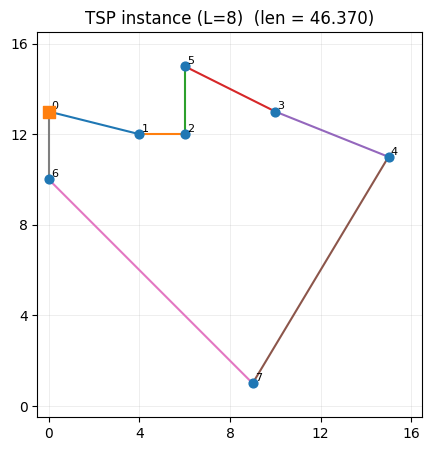

In [10]:
x_val, y_val = next(iter(val_loader))
_ = plot_tsp_instance_from_tokens(
    x_val[0], y_val[0], cfg.grid_size,
    annotate=True,
    title=f"TSP instance (L={cfg.n_cities})"
)
plt.show()

In [11]:

def exact_match_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = logits.argmax(dim=-1)              # [B, L]
    return (preds == y_true).all(dim=1).float()

def token_ce_loss(logits: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    B, L, V = logits.shape
    return F.cross_entropy(logits.reshape(B * L, V), y_true.reshape(B * L))



# Hyperparameters for structural regularization
ENFORCE_NO_SELF = True        # forbid s[i] = i
LAMBDA_PERM = 0.2             # column-sum (permutation) penalty weight
LAMBDA_2CYCLE = 0.05          # 2-cycle penalty weight (keep small)
LAMBDA_PREVCE = 0.2             # NEW: predecessor cross-entropy weight



from torch.nn.utils import clip_grad_norm_


def build_predecessor_targets(y_true: torch.Tensor) -> torch.Tensor:
    """
    y_true[b, i] = successor of i. Return prev[b, j] = predecessor of j.
    Shapes: y_true and return are [B, L] with ints in [0, L-1].
    """
    B, L = y_true.shape
    ar = torch.arange(L, device=y_true.device).unsqueeze(0).expand(B, L)  # indices i
    prev = torch.empty_like(y_true)
    prev.scatter_(1, y_true, ar)  # for each i, set prev[ successor(i) ] = i
    return prev





def train_one_epoch(
    model: TRM,
    loader: DataLoader,
    optimizer,
    scaler,
    epoch: int,
    use_amp: bool = True,
    ema: "EMA | None" = None,
    halt_weight: float = 0.0,
    distance_prior_strength: float = 0.0,    # NEW: geometric prior (0.0 turns it off)
    grid_size: int | None = None,            # NEW: pass cfg_data.grid_size
):
    model.train()
    total_ce, total_perm, total_2cyc, total_prevce = 0.0, 0.0, 0.0, 0.0
    total_halt, total_em, total_steps = 0.0, 0.0, 0

    is_cuda = (device.type == "cuda")
    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device, non_blocking=True)
        y_true   = y_true.to(device,   non_blocking=True)

        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)

        for _ in range(N_SUP):
            optimizer.zero_grad(set_to_none=True)
            with amp_autocast(is_cuda, use_amp):
                y_state, z_state, logits, halt_logit = model.forward_step(
                    x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=K_LAST_OPS
                )

                # Mask self transitions
                L = logits.shape[1]
                ar = torch.arange(L, device=logits.device)
                logits_eff = logits              
                
                
                if ENFORCE_NO_SELF:
                    logits_eff = logits.clone()
                    logits_eff[:, ar, ar] -= 1e9

                # Optional geometric prior: subtract a small multiple of pairwise distances
                if distance_prior_strength > 0.0:
                    # decode integer coords on-device
                    gx = (x_tokens % grid_size).float()
                    gy = (x_tokens // grid_size).float()
                    # pairwise Euclidean distances [B, L, L]
                    dx = gx.unsqueeze(2) - gx.unsqueeze(1)
                    dy = gy.unsqueeze(2) - gy.unsqueeze(1)
                    dist = torch.sqrt(dx * dx + dy * dy).to(logits_eff.dtype)
                    # normalize by per-batch mean off-diagonal distance
                    mean_offdiag = dist.sum(dim=(1,2)) / (L*L - L)
                    dist_norm = dist / mean_offdiag.view(-1, 1, 1)
                    logits_eff = logits_eff - distance_prior_strength * dist_norm
                    
                # tiny anti-symmetry penalty on logits (helps break i<->j pairs)
                sym_logits = logits_eff + logits_eff.transpose(1, 2)   # [B, L, L]
                eye = torch.eye(L, device=logits_eff.device, dtype=torch.bool)
                sym_logits = sym_logits.masked_fill(eye, 0.0)          # ignore diagonal
                loss_sym = (sym_logits ** 2).mean()
                # You can expose the weight as a hyperparam; start with 1e-3 and lower if needed.
                GAMMA_SYM = 1e-3

                # Row-softmax probabilities
                probs = F.softmax(logits_eff.float(), dim=-1)  # [B, L, L] with rows summing to 1

                # Standard CE on successors
                B, L, V = logits_eff.shape
                loss_ce = F.cross_entropy(logits_eff.float().reshape(B * L, V), y_true.reshape(B * L))

                # Column-sum penalty toward 1 (permutation-like)
                col_sum = probs.sum(dim=1)                         # [B, L]
                loss_perm = F.mse_loss(col_sum, torch.ones_like(col_sum))

                # 2-cycle penalty: sum_{i != j} p(i->j) * p(j->i)
                two_cycle_all = (probs * probs.transpose(1, 2)).sum(dim=(1, 2))
                diag_sq = (probs.diagonal(dim1=1, dim2=2) ** 2).sum(dim=1)
                loss_2cycle = (two_cycle_all - diag_sq).mean()

                # NEW: predecessor cross-entropy (columns)
                prev = build_predecessor_targets(y_true)           # [B, L] predecessor index per city
                probs_cols = probs.transpose(1, 2)                 # [B, L, L], distribution over predecessors for each city
                loss_prevce = F.cross_entropy(
                    (probs_cols + 1e-12).log().reshape(B * L, L),
                    prev.reshape(B * L)
                )

                # Halting (keep out of the objective early; still track it)
                with torch.no_grad():
                    em = (logits_eff.argmax(dim=-1) == y_true).all(dim=1).float()
                loss_halt = F.binary_cross_entropy_with_logits(halt_logit.float(), em)

                loss = (
                    loss_ce
                    + LAMBDA_PERM   * loss_perm
                    + LAMBDA_2CYCLE * loss_2cycle
                    + LAMBDA_PREVCE * loss_prevce
                    + halt_weight   * loss_halt
                    + GAMMA_SYM     * loss_sym
                )

            if use_amp:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            if ema is not None:
                ema.update(model)

            total_ce     += loss_ce.detach().item()
            total_perm   += loss_perm.detach().item()
            total_2cyc   += loss_2cycle.detach().item()
            total_prevce += loss_prevce.detach().item()
            total_halt   += loss_halt.detach().item()
            total_em     += em.mean().item()
            total_steps  += 1

    print(
        f"Epoch {epoch:02d} | CE {total_ce/max(1,total_steps):.4f} "
        f"| Perm {total_perm/max(1,total_steps):.4f} "
        f"| 2cyc {total_2cyc/max(1,total_steps):.4f} "
        f"| PrevCE {total_prevce/max(1,total_steps):.4f} "
        f"| HaltBCE {total_halt/max(1,total_steps):.4f} "
        f"| Exact-match {total_em/max(1,total_steps):.3f}"
    )





@torch.no_grad()
def evaluate(model: TRM, loader: DataLoader, n_sup_eval: int = N_SUP):
    model.eval()
    em_list, tok_acc_list, len_gap_list = [], [], []

    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device)
        y_true   = y_true.to(device)
        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)

        for _ in range(n_sup_eval):
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=K_LAST_OPS
            )

        L = logits.shape[1]
        ar = torch.arange(L, device=logits.device)
        logits_masked = logits.clone()
        logits_masked[:, ar, ar] = logits_masked[:, ar, ar] - 1e9
        preds = logits_masked.argmax(dim=-1)

        # token accuracy and exact-match
        em = (preds == y_true).all(dim=1).float()
        tok_acc = (preds == y_true).float().mean(dim=1)

        # tour length gap (pred minus ground truth) in Euclidean metric
        # decode per example
        x_np = x_tokens.detach().cpu().numpy()
        y_np = y_true.detach().cpu().numpy()
        p_np = preds.detach().cpu().numpy()
        for i in range(x_np.shape[0]):
            coords = decode_coords(x_np[i], cfg_data.grid_size)
            dist = distance_matrix(coords)
            gt_len = tour_length_from_successors(dist, y_np[i])
            pr_len = tour_length_from_successors(dist, p_np[i])
            len_gap_list.append(pr_len - gt_len)

        em_list.append(em)
        tok_acc_list.append(tok_acc)

    em = torch.cat(em_list).mean().item()
    tok_acc = torch.cat(tok_acc_list).mean().item()
    len_gap = float(np.mean(len_gap_list)) if len_gap_list else 0.0
    print(f"Validation | Exact-match {em:.3f} | Token accuracy {tok_acc:.3f} | Avg tour length gap {len_gap:.3f}")
    return em, tok_acc, len_gap

@torch.no_grad()
def evaluate_with_ema(model: TRM, ema: EMA, loader: DataLoader, n_sup_eval: int = N_SUP):
    with use_ema_weights(model, ema):
        return evaluate(model, loader, n_sup_eval=n_sup_eval)


In [12]:
# One forward-only sanity batch
x_tokens, y_true = next(iter(train_loader))
x_tokens = x_tokens.to(device)
y_true   = y_true.to(device)

model.eval()
with torch.no_grad():
    y0, z0 = model.init_state(batch_size=x_tokens.size(0), device=device)
    y1, z1, logits, halt_logit = model.forward_step(
        x_tokens, y=y0, z=z0, n=N, T=T, k_last_ops=K_LAST_OPS
    )
print("Forward-only finiteness:",
      "y1", torch.isfinite(y1).all().item(),
      "z1", torch.isfinite(z1).all().item(),
      "logits", torch.isfinite(logits).all().item(),
      "halt_logit", torch.isfinite(halt_logit).all().item())

# Single FP32 step to ensure gradients flow
model.train()
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.0)
opt.zero_grad(set_to_none=True)

y0, z0 = model.init_state(batch_size=x_tokens.size(0), device=device)
y1, z1, logits, halt_logit = model.forward_step(
    x_tokens, y=y0, z=z0, n=N, T=T, k_last_ops=K_LAST_OPS
)

loss_ce = F.cross_entropy(logits.float().reshape(-1, OUTPUT_TOKENS), y_true.reshape(-1))
em = (logits.argmax(dim=-1) == y_true).all(dim=1).float()
loss_halt = F.binary_cross_entropy_with_logits(halt_logit.float(), em)
loss = loss_ce + loss_halt
print("Pre-backward finiteness:",
      "loss", torch.isfinite(loss).item(),
      "loss_ce", torch.isfinite(loss_ce).item(),
      "loss_halt", torch.isfinite(loss_halt).item())
loss.backward()

all_grads_finite = True
for n, p in model.named_parameters():
    if p.grad is None:
        continue
    if not torch.isfinite(p.grad).all():
        print("Non-finite grad in:", n)
        all_grads_finite = False
        break
print("Gradients finite:", all_grads_finite)
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
opt.step()

# Post-step forward
model.eval()
with torch.no_grad():
    y0, z0 = model.init_state(batch_size=x_tokens.size(0), device=device)
    y2, z2, logits2, halt2 = model.forward_step(
        x_tokens, y=y0, z=z0, n=N, T=T, k_last_ops=K_LAST_OPS
    )
print("Post-step forward finiteness:",
      "y2", torch.isfinite(y2).all().item(),
      "z2", torch.isfinite(z2).all().item(),
      "logits2", torch.isfinite(logits2).all().item(),
      "halt2", torch.isfinite(halt2).all().item())


Forward-only finiteness: y1 True z1 True logits True halt_logit True
Pre-backward finiteness: loss True loss_ce True loss_halt True
Gradients finite: True
Post-step forward finiteness: y2 True z2 True logits2 True halt2 True


In [13]:


# FINAL evaluate override: 5 metrics, path-based
import numpy as np
import torch

def _is_single_cycle_local(successor: np.ndarray) -> bool:
    n = len(successor)
    seen = np.zeros(n, dtype=bool)
    cur = 0
    for _ in range(n):
        if seen[cur]:
            return False
        seen[cur] = True
        cur = int(successor[cur])
    return cur == 0 and seen.all()

def _tour_length_from_path(dist: np.ndarray, path: list[int]) -> float:
    return float(sum(dist[path[i], path[i+1]] for i in range(len(path) - 1)))



from scipy.optimize import linear_sum_assignment

@torch.no_grad()
def decode_hungarian(logits: torch.Tensor) -> torch.Tensor:
    B, L, _ = logits.shape
    preds = []
    for b in range(B):
        M = logits[b].detach().cpu().numpy().copy()
        np.fill_diagonal(M, -1e9)               # forbid self loops
        r, c = linear_sum_assignment(-M)        # maximize sum of logits
        preds.append(torch.from_numpy(c).long())
    return torch.stack(preds, dim=0).to(logits.device)




@torch.no_grad()
def evaluate(model: TRM, loader: DataLoader, n_sup_eval: int = N_SUP):
    model.eval()
    em_arg_list, em_hun_list, tok_acc_list = [], [], []
    cover_list, valid_list, gap_list = [], [], []

    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device)
        y_true   = y_true.to(device)

        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
        for _ in range(n_sup_eval):
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=K_LAST_OPS
            )

        L = logits.shape[1]
        ar = torch.arange(L, device=logits.device)
        logits_masked = logits.clone()
        logits_masked[:, ar, ar] = logits_masked[:, ar, ar] - 1e9

        # Argmax decode
        preds_arg = logits_masked.argmax(dim=-1)           # [B, L]
        em_arg = (preds_arg == y_true).all(dim=1).float()
        tok_acc = (preds_arg == y_true).float().mean(dim=1)

        # Hungarian decode
        preds_hun = decode_hungarian(logits_masked)        # [B, L]
        em_hun = (preds_hun == y_true).all(dim=1).float()

        # Path-based metrics (keep using argmax predictions)
        x_np = x_tokens.detach().cpu().numpy()
        y_np = y_true.detach().cpu().numpy()
        p_np = preds_arg.detach().cpu().numpy()
        for i in range(x_np.shape[0]):
            coords = decode_coords(x_np[i], cfg_data.grid_size)
            dist = distance_matrix(coords)
            gt_path = path_from_successors(y_np[i], start=0)
            pr_path = path_from_successors(p_np[i], start=0)
            gt_len  = sum(dist[gt_path[k], gt_path[k+1]] for k in range(len(gt_path)-1))
            pr_len  = sum(dist[pr_path[k], pr_path[k+1]] for k in range(len(pr_path)-1))
            coverage = len(set(pr_path[:-1])) / SEQ_LEN
            cover_list.append(coverage)
            valid = _is_single_cycle_local(p_np[i])
            valid_list.append(1.0 if valid else 0.0)
            gap_list.append((pr_len - gt_len) if (coverage == 1.0 and valid) else np.nan)

        em_arg_list.append(em_arg)
        em_hun_list.append(em_hun)
        tok_acc_list.append(tok_acc)

    em_arg = torch.cat(em_arg_list).mean().item()
    em_hun = torch.cat(em_hun_list).mean().item()
    tok_acc = torch.cat(tok_acc_list).mean().item()
    coverage = float(np.nanmean(cover_list)) if cover_list else 0.0
    valid_rate = float(np.nanmean(valid_list)) if valid_list else 0.0
    gap_valid = float(np.nanmean([g for g in gap_list if not np.isnan(g)])) if any(not np.isnan(g) for g in gap_list) else float('nan')

    print(f"Validation | EM(arg) {em_arg:.3f} | EM(hung) {em_hun:.3f} | Token {tok_acc:.3f} | Coverage {coverage:.3f} | ValidCycle {valid_rate:.3f} | AvgGap(valid) {gap_valid:.3f}")
    return em_arg, em_hun, tok_acc, coverage, valid_rate, gap_valid





@torch.no_grad()
def evaluate_with_ema(model: TRM, ema: EMA, loader: DataLoader, n_sup_eval: int = N_SUP):
    with use_ema_weights(model, ema):
        return evaluate(model, loader, n_sup_eval=n_sup_eval)





In [14]:
# Initialize input embeddings with coordinate features
init_coord_embedding_(model, grid_size=cfg_data.grid_size, d_model=cfg_trm.d_model, seed=123)

# Verification: check a few tokens match the analytic features
def expected_feats(token_id: int, grid_size: int):
    import math
    x = token_id % grid_size
    y = token_id // grid_size
    xf = (x / (grid_size - 1)) * 2.0 - 1.0
    yf = (y / (grid_size - 1)) * 2.0 - 1.0
    r  = math.sqrt(xf*xf + yf*yf)
    th = math.atan2(yf, xf) / math.pi
    return np.array([xf, yf, xf*yf, xf*xf, yf*yf, r, th], dtype=np.float32)

with torch.no_grad():
    for token_id in [0, 1, cfg_data.grid_size - 1, cfg_data.grid_size*(cfg_data.grid_size - 1)]:
        got = model.input_emb.weight[token_id, :7].cpu().numpy()
        exp = expected_feats(token_id, cfg_data.grid_size)
        print(f"token {token_id}: max_abs_diff = {np.max(np.abs(got - exp)):.6f}")


token 0: max_abs_diff = 0.000000
token 1: max_abs_diff = 0.000000
token 15: max_abs_diff = 0.000000
token 240: max_abs_diff = 0.000000


In [15]:
x_tokens, y_true = next(iter(train_loader))
x_tokens = x_tokens.to(device)
y_true = y_true.to(device)
model.eval()
with torch.no_grad():
    y0, z0 = model.init_state(batch_size=x_tokens.size(0), device=device)
    y1, z1, logits, halt = model.forward_step(x_tokens, y=y0, z=z0, n=N, T=T, k_last_ops=K_LAST_OPS)
print("logits shape:", logits.shape)  # expect [B, L, L]


logits shape: torch.Size([32, 8, 8])


In [17]:
# Build a tiny train/val on 6 cities with exact labels
cfg_overfit = TSPConfig(n_cities=6, grid_size=16, solver="held_karp", seed=42)
train_small, val_small = get_tsp_loaders(n_train=64, n_val=64, batch_size=16, cfg=cfg_overfit)

# Rebuild dims and model (output vocab and seq_len changed!)
SEQ_LEN = cfg_overfit.n_cities
INPUT_TOKENS = cfg_overfit.grid_size * cfg_overfit.grid_size
OUTPUT_TOKENS = cfg_overfit.n_cities

cfg_trm_small = TRMConfig(
    input_vocab_size=INPUT_TOKENS,
    output_vocab_size=OUTPUT_TOKENS,
    seq_len=SEQ_LEN,
    d_model=128,
    n_layers=2,
    use_attention=True,
    n_heads=4,
    dropout=0.0,
    mlp_ratio=4.0,
    token_mlp_ratio=2.0,
    n=6, T=3, k_last_ops=6,
    stabilize_input_sums=True,
    use_pointer_output=True    
)

model = TRM(cfg_trm_small).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.0, betas=(0.9, 0.95))
scaler = make_grad_scaler(device.type == "cuda")
ema = EMA(model, decay=0.999)

init_coord_embedding_(model, grid_size=cfg_overfit.grid_size, d_model=cfg_trm_small.d_model, seed=123)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    train_one_epoch(model, train_small, optimizer, scaler, epoch,
                    use_amp=True, ema=ema, halt_weight=0.0)

    em_arg, em_hun, tok_raw, cov_raw, val_raw, gap_raw = evaluate(
        model, train_small, n_sup_eval=N_SUP
    )

    # choose the early-stop criterion you prefer
    if em_hun >= 0.80 or em_arg >= 0.80:
        print("Stopping early: training EM reached 0.80")
        break


Epoch 01 | CE 1.6405 | Perm 0.0563 | 2cyc 1.2146 | PrevCE 1.6082 | HaltBCE 0.8548 | Exact-match 0.000
Validation | EM(arg) 0.000 | EM(hung) 0.016 | Token 0.214 | Coverage 0.440 | ValidCycle 0.000 | AvgGap(valid) nan
Epoch 02 | CE 1.6094 | Perm 0.0115 | 2cyc 1.2030 | PrevCE 1.6030 | HaltBCE 0.8614 | Exact-match 0.000
Validation | EM(arg) 0.000 | EM(hung) 0.000 | Token 0.263 | Coverage 0.464 | ValidCycle 0.000 | AvgGap(valid) nan
Epoch 03 | CE 1.5992 | Perm 0.0039 | 2cyc 1.2013 | PrevCE 1.5971 | HaltBCE 0.8642 | Exact-match 0.000
Validation | EM(arg) 0.000 | EM(hung) 0.016 | Token 0.260 | Coverage 0.474 | ValidCycle 0.000 | AvgGap(valid) nan
Epoch 04 | CE 1.5895 | Perm 0.0032 | 2cyc 1.2017 | PrevCE 1.5878 | HaltBCE 0.8658 | Exact-match 0.000
Validation | EM(arg) 0.000 | EM(hung) 0.016 | Token 0.292 | Coverage 0.461 | ValidCycle 0.000 | AvgGap(valid) nan
Epoch 05 | CE 1.5726 | Perm 0.0043 | 2cyc 1.2020 | PrevCE 1.5704 | HaltBCE 0.8667 | Exact-match 0.000
Validation | EM(arg) 0.000 | EM(hu

In [ ]:
# 8-city exact data
cfg_data = TSPConfig(n_cities=8, grid_size=16, solver="held_karp", seed=123)
train_loader, val_loader = get_tsp_loaders(n_train=4096, n_val=512, batch_size=16, cfg=cfg_data)

SEQ_LEN = cfg_data.n_cities
INPUT_TOKENS = cfg_data.grid_size * cfg_data.grid_size
OUTPUT_TOKENS = cfg_data.n_cities

D_MODEL = 192
N_SUP   = 12
N       = 6
T       = 3
K_LAST_OPS = None

cfg_trm = TRMConfig(
    input_vocab_size=INPUT_TOKENS,
    output_vocab_size=OUTPUT_TOKENS,
    seq_len=SEQ_LEN,
    d_model=D_MODEL,
    n_layers=2,
    use_attention=True,
    n_heads=6,                 # 192 / 6 = 32 per head
    dropout=0.0,
    mlp_ratio=4.0,
    token_mlp_ratio=2.0,
    n=N, T=T, k_last_ops=K_LAST_OPS,
    stabilize_input_sums=True,
    use_pointer_output=True 
)
model = TRM(cfg_trm).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.0, betas=(0.9, 0.95))
scaler = make_grad_scaler(device.type == "cuda")
ema = EMA(model, decay=0.999)

init_coord_embedding_(model, grid_size=cfg_data.grid_size, d_model=cfg_trm.d_model, seed=123)
# Optional: freeze for 1 epoch
for p in model.input_emb.parameters():
    p.requires_grad = False

EPOCHS = 200
for epoch in range(1, EPOCHS + 1):

    # --- structure schedule ---
    if epoch <= 10:
        LAMBDA_PERM, LAMBDA_2CYCLE, LAMBDA_PREVCE = 1.0, 0.30, 0.50
    elif epoch <= 20:
        LAMBDA_PERM, LAMBDA_2CYCLE, LAMBDA_PREVCE = 0.50, 0.15, 0.30
    else:
        LAMBDA_PERM, LAMBDA_2CYCLE, LAMBDA_PREVCE = 0.20, 0.05, 0.20

    # --- geometry prior schedule (see B) ---
    if epoch <= 5:
        dp = 0.25
    elif epoch <= 15:
        dp = 0.12
    else:
        dp = 0.00

    halt_w = 0.0 if epoch <= 3 else 1.0

    train_one_epoch(
        model, train_loader, optimizer, scaler, epoch,
        use_amp=True, ema=ema, halt_weight=halt_w,
        distance_prior_strength=dp,                 # NEW
        grid_size=cfg_data.grid_size,               # NEW
    )

    if epoch == 1:
        for p in model.input_emb.parameters():
            p.requires_grad = True
        # optional: keep momentum on other params and give a lower LR to the embedding
        optimizer = torch.optim.AdamW(
            [
                {"params": [p for n,p in model.named_parameters() if "input_emb" not in n], "lr": 3e-4},
                {"params": model.input_emb.parameters(), "lr": 1e-4},
            ],
            weight_decay=0.0, betas=(0.9, 0.95)
        )

    em_arg, em_hun, tok_raw, cov_raw, val_raw, gap_raw = evaluate(
        model, val_loader, n_sup_eval=N_SUP
    )
    
    em_arg_ema, em_hun_ema, tok_ema, cov_ema, val_ema, gap_ema = evaluate_with_ema(
        model, ema, val_loader, n_sup_eval=N_SUP
    )
    
    print(
        f"Validation (raw) | EM(arg) {em_arg:.3f} | EM(hung) {em_hun:.3f} "
        f"| Tok {tok_raw:.3f} | Cov {cov_raw:.3f} | Valid {val_raw:.3f} | Gap(valid) {gap_raw:.3f}"
    )
    print(
        f"Validation (EMA) | EM(arg) {em_arg_ema:.3f} | EM(hung) {em_hun_ema:.3f} "
        f"| Tok {tok_ema:.3f} | Cov {cov_ema:.3f} | Valid {val_ema:.3f} | Gap(valid) {gap_ema:.3f}"
    )
    

Epoch 01 | CE 1.7286 | Perm 0.0153 | 2cyc 1.3135 | PrevCE 1.7207 | HaltBCE 1.2177 | Exact-match 0.000
Validation | EM(arg) 0.000 | EM(hung) 0.004 | Token 0.414 | Coverage 0.313 | ValidCycle 0.000 | AvgGap(valid) nan
Validation | EM(arg) 0.000 | EM(hung) 0.002 | Token 0.137 | Coverage 0.419 | ValidCycle 0.000 | AvgGap(valid) nan
Validation (raw) | EM(arg) 0.000 | EM(hung) 0.004 | Tok 0.414 | Cov 0.313 | Valid 0.000 | Gap(valid) nan
Validation (EMA) | EM(arg) 0.000 | EM(hung) 0.002 | Tok 0.137 | Cov 0.419 | Valid 0.000 | Gap(valid) nan
Epoch 02 | CE 1.7371 | Perm 0.0135 | 2cyc 1.3701 | PrevCE 1.7301 | HaltBCE 1.1825 | Exact-match 0.000
Validation | EM(arg) 0.000 | EM(hung) 0.000 | Token 0.004 | Coverage 0.350 | ValidCycle 0.000 | AvgGap(valid) nan
Validation | EM(arg) 0.000 | EM(hung) 0.002 | Token 0.393 | Coverage 0.325 | ValidCycle 0.000 | AvgGap(valid) nan
Validation (raw) | EM(arg) 0.000 | EM(hung) 0.000 | Tok 0.004 | Cov 0.350 | Valid 0.000 | Gap(valid) nan
Validation (EMA) | EM(arg

In [67]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    halt_w = 0.0 if epoch <= 3 else 1.0
    train_one_epoch(model, train_loader, optimizer, scaler, epoch, use_amp=True, ema=ema, halt_weight=halt_w)

    em_raw, tok_raw, cover_raw, valid_raw, gap_raw = evaluate(model, val_loader, n_sup_eval=N_SUP)
    em_ema, tok_ema, cover_ema, valid_ema, gap_ema = evaluate_with_ema(model, ema, val_loader)

    print(f"Validation (raw) | EM {em_raw:.3f} | Tok {tok_raw:.3f} | Cov {cover_raw:.3f} | Valid {valid_raw:.3f} | Gap(valid) {gap_raw:.3f}")
    print(f"Validation (EMA) | EM {em_ema:.3f} | Tok {tok_ema:.3f} | Cov {cover_ema:.3f} | Valid {valid_ema:.3f} | Gap(valid) {gap_ema:.3f}")



Epoch 01 | CE 2.1363 | HaltBCE 0.6783 | Exact-match 0.000
Validation | EM 0.000 | Token 0.126 | Coverage 0.393 | ValidCycle 0.000 | AvgGap(valid) nan
Validation | EM 0.000 | Token 0.121 | Coverage 0.366 | ValidCycle 0.000 | AvgGap(valid) nan
Validation (raw) | EM 0.000 | Tok 0.126 | Cov 0.393 | Valid 0.000 | Gap(valid) nan
Validation (EMA) | EM 0.000 | Tok 0.121 | Cov 0.366 | Valid 0.000 | Gap(valid) nan


KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def show_tsp_solutions(model: TRM, loader: DataLoader, n_batches: int = 1):
    model.eval()
    shown = 0
    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device)
        y_true   = y_true.to(device)
        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
        for _ in range(N_SUP):
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=K_LAST_OPS
            )
        
        L = logits.shape[1]
        ar = torch.arange(L, device=logits.device)
        logits_masked = logits.clone()
        logits_masked[:, ar, ar] = logits_masked[:, ar, ar] - 1e9
        preds = logits_masked.argmax(dim=-1).cpu().numpy()

        xs = x_tokens.cpu().numpy()
        ys = y_true.cpu().numpy()
        for i in range(min(4, xs.shape[0])):
            coords = decode_coords(xs[i], cfg_data.grid_size)
            dist = distance_matrix(coords)
            gt_path = path_from_successors(ys[i], start=0)
            pr_path = path_from_successors(preds[i], start=0)
            gt_len = tour_length_from_successors(dist, ys[i])
            pr_len = tour_length_from_successors(dist, preds[i])
            print(f"\nItem {shown+i}:")
            print("GT path:", gt_path, f" | length={gt_len:.3f}")
            print("PR path:", pr_path, f" | length={pr_len:.3f}")
        shown += 1
        if shown >= n_batches:
            break

show_tsp_solutions(model, val_loader, n_batches=1)



Item 0:
GT path: [0, 1, 2, 5, 3, 4, 7, 6, 0]  | length=46.370
PR path: [0, 6, 0]  | length=24.000

Item 1:
GT path: [0, 6, 4, 5, 1, 3, 2, 7, 0]  | length=35.749
PR path: [0, 5, 0]  | length=83.522

Item 2:
GT path: [0, 3, 2, 5, 6, 4, 1, 7, 0]  | length=45.539
PR path: [0, 7, 4, 2, 0]  | length=85.378

Item 3:
GT path: [0, 5, 2, 1, 4, 6, 3, 7, 0]  | length=41.068
PR path: [0, 5, 0]  | length=4.000


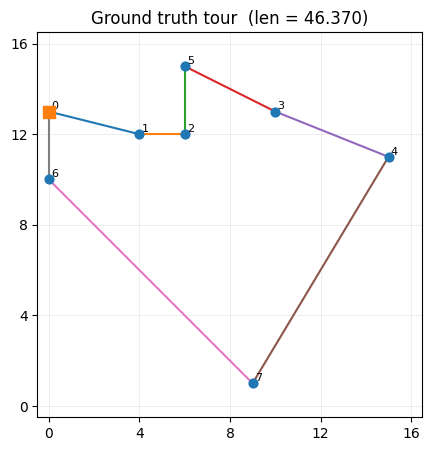

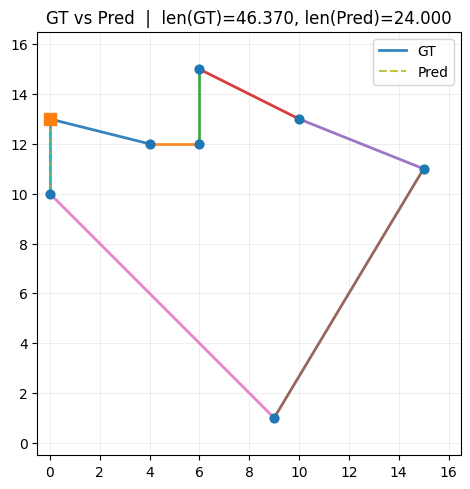

In [ ]:
from tsp_data import plot_tsp_instance_from_tokens, plot_tsp_compare_from_tokens
import matplotlib.pyplot as plt

# pick one batch from validation
x_val, y_val = next(iter(val_loader))

# plot ground truth
_ = plot_tsp_instance_from_tokens(x_val[0], y_val[0], cfg_data.grid_size, annotate=True, title="Ground truth tour")
plt.show()

# if you have logits from evaluation above, overlay prediction vs GT
with torch.no_grad():
    y0, z0 = model.init_state(batch_size=x_val.size(0), device=device)
    y1, z1, logits, _ = model.forward_step(x_val.to(device), y=y0, z=z0, n=N, T=T, k_last_ops=K_LAST_OPS)
pred = logits.argmax(dim=-1).cpu()
_ = plot_tsp_compare_from_tokens(x_val[0], y_val[0], pred[0], cfg_data.grid_size, annotate=False, title="GT vs Pred")
plt.show()


In [ ]:
# logits: [B, L, V] with V = cfg.n_cities
with torch.no_grad():
    preds = logits.argmax(dim=-1)  # [B, L]

_ = plot_tsp_compare_from_tokens(
    x_val[0], y_val[0], preds[0], cfg.grid_size,
    annotate=False,
    title="Ground truth vs model"
)
plt.show()


In [ ]:
cfg_trm = TRMConfig(
    input_vocab_size=INPUT_TOKENS,
    output_vocab_size=OUTPUT_TOKENS,
    seq_len=SEQ_LEN,
    d_model=128,           # or 256 if you like
    n_layers=2,
    use_attention=True,    # for TSP, attention often helps; Mixer can also work since L <= D
    n_heads=8,
    dropout=0.0,
    mlp_ratio=4.0,
    token_mlp_ratio=2.0,
    n=6,
    T=3,
    stabilize_input_sums=True
)


In [2]:
import exploretinyrm as m
print(m.__version__)

%load_ext autoreload
%autoreload 2

import torch
from exploretinyrm.utils import compute_tensor_summary  


0.1.0


In [33]:

import os, math, random
from dataclasses import dataclass
from typing import Tuple
from typing import List, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader


import sys
sys.path.append("src")

from exploretinyrm.trm import TRM, TRMConfig

def set_seed(seed: int = 123):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [11]:
from pathlib import Path
import os, json, random
import matplotlib.pyplot as plt

from tsp_data_gen import (
    write_dataset,
    demo_once,
    dataset_stats,
    show_examples,
    pairwise_euclidean,
    tour_length
)

output_dir = Path("data")
output_dir.mkdir(exist_ok=True)
output_path = str(output_dir / "tsp_train_small.jsonl")


In [5]:
demo_once(n=10, seed=42, noise_k=3)

Demo TSP with n=10, seed=42
City coordinates (index: x y):
   0: 0.3745 0.9507
   1: 0.7320 0.5987
   2: 0.1560 0.1560
   3: 0.0581 0.8662
   4: 0.6011 0.7081
   5: 0.0206 0.9699
   6: 0.8324 0.2123
   7: 0.1818 0.1834
   8: 0.3042 0.5248
   9: 0.4319 0.2912

Cheapest Insertion trajectory:
  step  0: insert city 3 at position 3; len 2.6143 -> 2.6164 (delta +0.0021)
    partial tour: [5, 6, 2]
  step  1: insert city 7 at position 2; len 2.6164 -> 2.6265 (delta +0.0101)
    partial tour: [5, 6, 2, 3]
  step  2: insert city 9 at position 2; len 2.6265 -> 2.6558 (delta +0.0293)
    partial tour: [5, 6, 7, 2, 3]
  step  3: insert city 8 at position 1; len 2.6558 -> 2.6869 (delta +0.0311)
    partial tour: [5, 6, 9, 7, 2, 3]
  step  4: insert city 1 at position 2; len 2.6869 -> 2.9065 (delta +0.2196)
    partial tour: [5, 8, 6, 9, 7, 2, 3]
  step  5: insert city 4 at position 2; len 2.9065 -> 2.9919 (delta +0.0854)
    partial tour: [5, 8, 1, 6, 9, 7, 2, 3]
  step  6: insert city 0 at positi

In [7]:
number_of_problems = 800       # total problems to sample
n_min, n_max = 6, 12           # instance size range
prob_constructive = 0.8         # mix of constructive vs improvement samples
insert_steps_per_problem = 6    # number of mid-trajectory insert snapshots per problem
two_opt_steps_per_problem = 4   # number of mid-trajectory 2-opt snapshots per problem
step_sampling = "mid"           # "uniform" | "early" | "mid" | "late" | "all"
noise_min, noise_max = 2, 4     # random 2-opt noise before improvement trajectory
include_stop_probability = 0.20 # occasionally include a STOP example

In [8]:

write_dataset(
    out_path=output_path,
    num_problems=number_of_problems,
    n_min=n_min,
    n_max=n_max,
    seed=1234,
    p_constructive=prob_constructive,
    ins_per=insert_steps_per_problem,
    opt_per=two_opt_steps_per_problem,
    step_sample=step_sampling,
    noise_min=noise_min,
    noise_max=noise_max,
    include_stop_prob=include_stop_probability
)

print("Wrote:", output_path)

Wrote: data/tsp_train_small.jsonl


In [9]:
show_examples(output_path, k=5)

Showing 5 examples from 2089 lines:

----------------------------
line 214: mode=insert n=10 step=3/7 teacher=cheapest_insertion
tour_partial: [0, 1, 6, 7, 5, 3]
action: insert city 9 at position 3
cost_before -> cost_after: 2.3462 -> 2.3522

----------------------------
line 357: mode=insert n=12 step=5/9 teacher=cheapest_insertion
tour_partial: [5, 0, 1, 6, 4, 8, 10, 7]
action: insert city 3 at position 6
cost_before -> cost_after: 2.6975 -> 2.7662

----------------------------
line 1091: mode=insert n=12 step=5/9 teacher=cheapest_insertion
tour_partial: [0, 2, 6, 4, 8, 7, 5, 10]
action: insert city 3 at position 2
cost_before -> cost_after: 2.5198 -> 2.5776

----------------------------
line 1096: mode=insert n=11 step=2/8 teacher=cheapest_insertion
tour_partial: [7, 6, 10, 0, 9]
action: insert city 2 at position 1
cost_before -> cost_after: 2.5911 -> 2.5964

----------------------------
line 1668: mode=two_opt n=11 step=1/4 teacher=two_opt_best
action: 2-opt (i=4, j=7)
tour_full: [

In [10]:
dataset_stats(output_path)

Lines read: 2089
Mode counts: {'insert': 1089, 'two_opt': 1000}
n: min=6 max=12 mean=9.43
step_index/total_steps: mean=0.331 (0=early, ~0.5=mid, 1=late)
mean delta (cost_after - cost_before): -0.1170


In [12]:


def plot_insert_example(example: dict, figsize=(5,5)):
    assert example["mode"] == "insert"
    coords = np.array(example["coords"], dtype=np.float32)
    tour_partial = example["tour_partial"]
    action_city = example["action"]["city"]
    insert_position = example["action"]["position"]
    m = len(tour_partial)

    plt.figure(figsize=figsize)
    plt.scatter(coords[:, 0], coords[:, 1], s=40)
    for idx, (x, y) in enumerate(coords):
        plt.text(x, y, str(idx), ha="center", va="bottom")

    # Draw partial tour cycle
    for k in range(m):
        a = tour_partial[k]
        b = tour_partial[(k + 1) % m]
        plt.plot([coords[a, 0], coords[b, 0]], [coords[a, 1], coords[b, 1]])

    # Highlight the insertion edge that will be split
    u = tour_partial[(insert_position - 1) % m]
    v = tour_partial[(insert_position) % m]
    plt.plot([coords[u, 0], coords[v, 0]], [coords[u, 1], coords[v, 1]], linestyle="--", linewidth=2)

    # Highlight the city to insert
    plt.scatter([coords[action_city, 0]], [coords[action_city, 1]], s=110, marker="s")

    title = f"Insert step: city {action_city} at position {insert_position}\n" \
            f"cost {example['cost_before']:.4f} -> {example['cost_after']:.4f}"
    plt.title(title)
    plt.axis("equal")
    plt.show()


def plot_two_opt_example(example: dict, figsize=(5,5)):
    assert example["mode"] == "two_opt"
    coords = np.array(example["coords"], dtype=np.float32)
    tour_full = example["tour_full"]

    plt.figure(figsize=figsize)
    plt.scatter(coords[:, 0], coords[:, 1], s=40)
    for idx, (x, y) in enumerate(coords):
        plt.text(x, y, str(idx), ha="center", va="bottom")

    # Draw entire tour
    n = len(tour_full)
    for k in range(n):
        a = tour_full[k]
        b = tour_full[(k + 1) % n]
        plt.plot([coords[a, 0], coords[b, 0]], [coords[a, 1], coords[b, 1]])

    action = example["action"]
    if not action.get("stop", False):
        i = action["i"]
        j = action["j"]
        a = tour_full[i - 1]; b = tour_full[i]
        c = tour_full[j];     d = tour_full[(j + 1) % n]
        # Emphasize the two edges that will be replaced by the 2-opt swap
        plt.plot([coords[a, 0], coords[b, 0]], [coords[a, 1], coords[b, 1]], linewidth=3)
        plt.plot([coords[c, 0], coords[d, 0]], [coords[c, 1], coords[d, 1]], linewidth=3)
        title = f"2-opt step: (i={i}, j={j})  cost {example['cost_before']:.4f} -> {example['cost_after']:.4f}"
    else:
        title = f"2-opt STOP at cost {example['cost_before']:.4f}"

    plt.title(title)
    plt.axis("equal")
    plt.show()



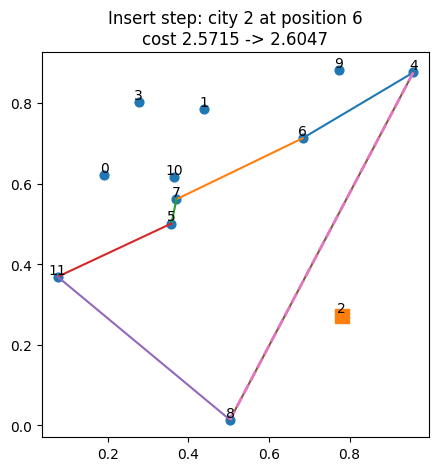

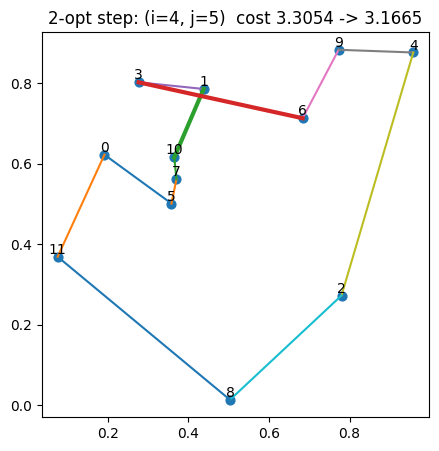

In [13]:

with open(output_path, "r") as f:
    lines = [json.loads(line) for _, line in zip(range(5000), f)]  # adjust cap as needed

insert_example = next(ex for ex in lines if ex["mode"] == "insert")
two_opt_example = next(ex for ex in lines if ex["mode"] == "two_opt" and not ex["action"].get("stop", False))


plot_insert_example(insert_example)

plot_two_opt_example(two_opt_example)



In [ ]:


def verify_insert(example: dict) -> bool:
    assert example["mode"] == "insert"
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour_before = example["tour_partial"]
    city = example["action"]["city"]
    position = example["action"]["position"]
    tour_after = tour_before[:position] + [city] + tour_before[position:]
    computed_before = tour_length(dist, tour_before)
    computed_after = tour_length(dist, tour_after)
    ok = (abs(computed_before - example["cost_before"]) < 1e-5) and (abs(computed_after - example["cost_after"]) < 1e-5)
    return bool(ok)


def verify_two_opt(example: dict) -> bool:
    assert example["mode"] == "two_opt"
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour_before = example["tour_full"]
    computed_before = tour_length(dist, tour_before)
    if example["action"].get("stop", False):
        # At STOP we only check that the stored cost matches the tour_before cost
        return abs(computed_before - example["cost_before"]) < 1e-5
    i = example["action"]["i"]
    j = example["action"]["j"]
    # Apply the 2-opt swap and recompute
    def two_opt_swap_py(tour, i, j):
        return tour[:i] + list(reversed(tour[i:j+1])) + tour[j+1:]
    tour_after = two_opt_swap_py(tour_before, i, j)
    computed_after = tour_length(dist, tour_after)
    ok1 = abs(computed_before - example["cost_before"]) < 1e-5
    ok2 = abs(computed_after - example["cost_after"]) < 1e-5
    return bool(ok1 and ok2)


# Run a quick check over a handful of samples
sampled = random.sample(lines, k=min(20, len(lines)))
results = []
for ex in sampled:
    if ex["mode"] == "insert":
        results.append(verify_insert(ex))
    else:
        results.append(verify_two_opt(ex))

print("Integrity check pass rate over sample:", sum(results), "/", len(results))



Integrity check pass rate over sample: 20 / 20


In [15]:

# Verify that the recorded insert is truly the cheapest among all city-position pairs
def verify_insert_is_cheapest(example):
    assert example["mode"] == "insert"
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour = example["tour_partial"]
    chosen_city = example["action"]["city"]
    chosen_pos  = example["action"]["position"]
    n = coords.shape[0]
    visited = set(tour)

    def delta(u, c, v): return float(dist[u, c] + dist[c, v] - dist[u, v])

    best = float("inf"); best_pair = None
    m = len(tour)
    for c in range(n):
        if c in visited:
            continue
        for pos in range(m):
            u, v = tour[pos], tour[(pos + 1) % m]
            d = delta(u, c, v)
            if d < best:
                best = d; best_pair = (c, pos + 1)
    return (chosen_city, chosen_pos) == best_pair


# Verify that the recorded 2-opt move is the best improvement available
def verify_two_opt_is_best(example):
    assert example["mode"] == "two_opt"
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour = example["tour_full"]
    n = len(tour)

    best_delta = 0.0; best_pair = (None, None)
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            delta = float(dist[a, c]) + float(dist[b, d]) - float(dist[a, b]) - float(dist[c, d])
            if delta < best_delta - 1e-12:
                best_delta = delta; best_pair = (i, j)

    if example["action"].get("stop", False):
        # No improving move should exist
        return best_pair == (None, None)
    else:
        return (example["action"]["i"], example["action"]["j"]) == best_pair


In [16]:
from tsp_data_gen import pairwise_euclidean  # make sure this import works

DATA_PATH = "data/tsp_train_small.jsonl"  # adjust if needed

# Load a few lines
with open(DATA_PATH, "r") as f:
    rows = [json.loads(line) for _, line in zip(range(5000), f)]

insert_ex = next(ex for ex in rows if ex["mode"] == "insert")
twoopt_ex = next(ex for ex in rows if ex["mode"] == "two_opt" and not ex["action"].get("stop", False))

print("Insert example cheapest? ", verify_insert_is_cheapest(insert_ex))
print("Two-opt example best?    ", verify_two_opt_is_best(twoopt_ex))


Insert example cheapest?  True
Two-opt example best?     True


In [17]:
rng = random.Random(0)
sample_size = min(300, len(rows))  # tune up or down
indices = sorted(rng.sample(range(len(rows)), k=sample_size))

insert_pass = insert_total = 0
twoopt_pass = twoopt_total = 0

for idx in indices:
    ex = rows[idx]
    if ex["mode"] == "insert":
        insert_total += 1
        insert_pass  += int(verify_insert_is_cheapest(ex))
    else:
        twoopt_total += 1
        twoopt_pass  += int(verify_two_opt_is_best(ex))

print(f"Insert:  {insert_pass}/{insert_total} passed")
print(f"Two-opt: {twoopt_pass}/{twoopt_total} passed")
print(f"Overall: {(insert_pass + twoopt_pass)}/{(insert_total + twoopt_total)} passed")


Insert:  152/152 passed
Two-opt: 148/148 passed
Overall: 300/300 passed


In [18]:
def explain_insert_failure(example):
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour = example["tour_partial"]
    chosen_city = example["action"]["city"]
    chosen_pos  = example["action"]["position"]
    n = coords.shape[0]
    visited = set(tour)
    m = len(tour)

    def delta(u, c, v): return float(dist[u, c] + dist[c, v] - dist[u, v])

    best = float("inf"); best_pair = None; chosen_delta = None
    for c in range(n):
        if c in visited:
            continue
        for pos in range(m):
            u, v = tour[pos], tour[(pos + 1) % m]
            d = delta(u, c, v)
            if c == chosen_city and (pos + 1) == chosen_pos:
                chosen_delta = d
            if d < best:
                best = d; best_pair = (c, pos + 1)
    print("Insert failure:")
    print("  chosen (city, pos):", (chosen_city, chosen_pos), "delta:", chosen_delta)
    print("  best   (city, pos):", best_pair, "delta:", best)

def explain_two_opt_failure(example):
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour = example["tour_full"]
    n = len(tour)

    best_delta = 0.0; best_pair = (None, None)
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            delta = float(dist[a, c]) + float(dist[b, d]) - float(dist[a, b]) - float(dist[c, d])
            if delta < best_delta - 1e-12:
                best_delta = delta; best_pair = (i, j)

    if example["action"].get("stop", False):
        print("Two-opt STOP failure: should have no improving move.")
        print("  best available delta:", best_delta, "pair:", best_pair)
    else:
        i0, j0 = example["action"]["i"], example["action"]["j"]
        print("Two-opt failure:")
        print("  chosen (i, j):", (i0, j0))
        print("  best   (i, j):", best_pair, "best delta:", best_delta)

# Stream the file and check
insert_pass = insert_total = 0
twoopt_pass = twoopt_total = 0
fail_show = 0
max_fail_show = 3

with open(DATA_PATH, "r") as f:
    for line in f:
        ex = json.loads(line)
        if ex["mode"] == "insert":
            insert_total += 1
            ok = verify_insert_is_cheapest(ex)
            insert_pass += int(ok)
            if not ok and fail_show < max_fail_show:
                explain_insert_failure(ex); fail_show += 1
        else:
            twoopt_total += 1
            ok = verify_two_opt_is_best(ex)
            twoopt_pass += int(ok)
            if not ok and fail_show < max_fail_show:
                explain_two_opt_failure(ex); fail_show += 1

print(f"\nInsert:  {insert_pass}/{insert_total} passed")
print(f"Two-opt: {twoopt_pass}/{twoopt_total} passed")
print(f"Overall: {(insert_pass + twoopt_pass)}/{(insert_total + twoopt_total)} passed")



Insert:  1089/1089 passed
Two-opt: 1000/1000 passed
Overall: 2089/2089 passed


In [19]:
# collect first failing examples for each mode
first_bad_insert = None
first_bad_twoopt = None

for ex in rows:
    if ex["mode"] == "insert" and not verify_insert_is_cheapest(ex) and first_bad_insert is None:
        first_bad_insert = ex
    if ex["mode"] == "two_opt" and not verify_two_opt_is_best(ex) and first_bad_twoopt is None:
        first_bad_twoopt = ex
    if first_bad_insert and first_bad_twoopt:
        break

if first_bad_insert:
    plot_insert_example(first_bad_insert)
if first_bad_twoopt:
    plot_two_opt_example(first_bad_twoopt)

if not first_bad_insert and not first_bad_twoopt:
    print("No failures found in the loaded rows.")


No failures found in the loaded rows.


In [25]:

DATA_PATH = "data/tsp_train_small.jsonl"   
BATCH_SIZE = 64

In [26]:
def load_jsonl_split(path):
    insert_list = []
    two_opt_list = []
    with open(path, "r") as f:
        for line in f:
            ex = json.loads(line)
            if ex["mode"] == "insert":
                tp = np.array(ex["tour_partial"], dtype=np.int64)  # [m]
                m = int(tp.shape[0])
                pos_raw = int(ex["action"]["position"])            # JSONL stores 1..m
                pos_edge = (pos_raw - 1) % m                       # map to 0..m-1

                insert_list.append({
                    "coords": np.array(ex["coords"], dtype=np.float32),  # [n,2]
                    "tour_partial": tp,                                  # [m]
                    "target_city": int(ex["action"]["city"]),
                    "target_position": int(pos_edge)                     # 0..m-1 for classifier
                })
            else:
                act = ex["action"]
                stop = bool(act.get("stop", False))
                target_i = -1 if stop else int(act["i"])
                target_j = -1 if stop else int(act["j"])
                two_opt_list.append({
                    "coords": np.array(ex["coords"], dtype=np.float32),     # [n,2]
                    "tour_full": np.array(ex["tour_full"], dtype=np.int64), # [n]
                    "stop": stop,
                    "target_i": target_i,
                    "target_j": target_j
                })
    return insert_list, two_opt_list

insert_examples, two_opt_examples = load_jsonl_split(DATA_PATH)
print(f"Loaded: insert={len(insert_examples)}  two_opt={len(two_opt_examples)}")



Loaded: insert=1089  two_opt=1000


In [27]:
class InsertDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def collate_insert(batch):
    batch_size = len(batch)
    n_max = max(item["coords"].shape[0] for item in batch)
    m_max = max(item["tour_partial"].shape[0] for item in batch)

    coords = torch.zeros(batch_size, n_max, 2, dtype=torch.float32)
    visited_mask = torch.zeros(batch_size, n_max, dtype=torch.float32)
    partial_tour = torch.full((batch_size, m_max), -1, dtype=torch.long)
    partial_length = torch.zeros(batch_size, dtype=torch.long)
    target_city = torch.zeros(batch_size, dtype=torch.long)
    target_position = torch.zeros(batch_size, dtype=torch.long)

    for b, item in enumerate(batch):
        n = item["coords"].shape[0]
        m = item["tour_partial"].shape[0]
        coords[b, :n] = torch.from_numpy(item["coords"])
        partial_tour[b, :m] = torch.from_numpy(item["tour_partial"])
        partial_length[b] = m
        target_city[b] = item["target_city"]
        target_position[b] = item["target_position"]
        # build visited mask from the partial tour
        for v in item["tour_partial"]:
            visited_mask[b, int(v)] = 1.0

    return {
        "coords": coords,                         # [B, Nmax, 2]
        "visited_mask": visited_mask,             # [B, Nmax] 1=visited
        "partial_tour": partial_tour,             # [B, Mmax] with -1 pad
        "partial_length": partial_length,         # [B]
        "target_city": target_city,               # [B]
        "target_position": target_position        # [B]
    }

class TwoOptDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def enumerate_two_opt_pairs(tour):
    # valid 2-opt pairs under standard adjacency constraints
    n = len(tour)
    pairs = []
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            pairs.append((i, j))
    return pairs

def collate_two_opt_pairclass(batch):
    # Build a per-sample catalogue of candidate pairs and target index, with a STOP class
    batch_size = len(batch)
    n_max = max(item["coords"].shape[0] for item in batch)

    coords = torch.zeros(batch_size, n_max, 2, dtype=torch.float32)
    tour_full = torch.full((batch_size, n_max), -1, dtype=torch.long)
    n_nodes = torch.zeros(batch_size, dtype=torch.long)

    candidate_lists = []
    target_indices = []
    for b, item in enumerate(batch):
        n = item["coords"].shape[0]
        coords[b, :n] = torch.from_numpy(item["coords"])
        tour_full[b, :n] = torch.from_numpy(item["tour_full"])
        n_nodes[b] = n

        pairs = enumerate_two_opt_pairs(item["tour_full"].tolist())
        pair_to_index = {p: k for k, p in enumerate(pairs)}
        if item["stop"]:
            target_idx = len(pairs)  # STOP class at the end
        else:
            target_idx = pair_to_index[(item["target_i"], item["target_j"])]
        candidate_lists.append(pairs)
        target_indices.append(target_idx)

    # Pad the candidate pair lists and build masks
    L = max(len(pairs) + 1 for pairs in candidate_lists)  # +1 for STOP
    pair_indices = torch.full((batch_size, L, 2), -1, dtype=torch.long)  # holds (i,j)
    pair_mask = torch.zeros(batch_size, L, dtype=torch.bool)              # True where valid
    for b, pairs in enumerate(candidate_lists):
        K = len(pairs)
        if K > 0:
            pair_indices[b, :K] = torch.tensor(pairs, dtype=torch.long)
        # mark K pairs plus one STOP slot as valid classes
        pair_mask[b, :K+1] = True

    target_pair_index = torch.tensor(target_indices, dtype=torch.long)

    return {
        "coords": coords,                   # [B, Nmax, 2]
        "tour_full": tour_full,             # [B, Nmax] with -1 pad
        "n_nodes": n_nodes,                 # [B]
        "pair_indices": pair_indices,       # [B, L, 2], entries -1 are padding
        "pair_mask": pair_mask,             # [B, L], True for valid classes (K pairs + STOP)
        "target_pair_index": target_pair_index  # [B], in [0..K] where K is STOP
    }


In [28]:
insert_loader = DataLoader(
    InsertDataset(insert_examples),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_insert,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

two_opt_loader = DataLoader(
    TwoOptDataset(two_opt_examples),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_two_opt_pairclass,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

insert_batch = next(iter(insert_loader))
two_opt_batch = next(iter(two_opt_loader))

def brief_shapes(name, batch):
    print(f"\n{name}")
    for k, v in batch.items():
        if torch.is_tensor(v):
            print(f"  {k:18s} {tuple(v.shape)} {v.dtype}")
        else:
            print(f"  {k:18s} {type(v)}")

brief_shapes("Insert batch", insert_batch)
brief_shapes("Two-opt batch", two_opt_batch)

# A couple of sanity asserts you can keep
B, Nmax = insert_batch["coords"].shape[:2]
assert (insert_batch["target_city"] < Nmax).all()
assert (insert_batch["target_position"] < insert_batch["partial_length"]).all()

B2, Lmax = two_opt_batch["pair_mask"].shape
assert (two_opt_batch["target_pair_index"] < Lmax).all()



Insert batch
  coords             (64, 12, 2) torch.float32
  visited_mask       (64, 12) torch.float32
  partial_tour       (64, 8) torch.int64
  partial_length     (64,) torch.int64
  target_city        (64,) torch.int64
  target_position    (64,) torch.int64

Two-opt batch
  coords             (64, 12, 2) torch.float32
  tour_full          (64, 12) torch.int64
  n_nodes            (64,) torch.int64
  pair_indices       (64, 46, 2) torch.int64
  pair_mask          (64, 46) torch.bool
  target_pair_index  (64,) torch.int64


In [30]:
# save (unchanged)
checkpoint_path = "data/tsp_ready.pt"
payload = {
    "insert_examples": insert_examples,
    "two_opt_examples": two_opt_examples,
    "meta": {
        "source": DATA_PATH,
        "counts": {"insert": len(insert_examples), "two_opt": len(two_opt_examples)}
    }
}
torch.save(payload, checkpoint_path)
print("Saved checkpoint:", checkpoint_path)

# load with weights_only=False (explicitly allow general pickled objects)
reloaded = torch.load(checkpoint_path, weights_only=False)
print("Reloaded counts:", len(reloaded["insert_examples"]), len(reloaded["two_opt_examples"]))


Saved checkpoint: data/tsp_ready.pt
Reloaded counts: 1089 1000


In [31]:

# Minimal wrappers around tsp_data_gen.write_dataset
import os
from tsp_data_gen import write_dataset

def make_dataset_pairs_only(
    out_path: str,
    num_problems: int = 4000,
    n_min: int = 6,
    n_max: int = 12,
    seed: int = 1234,
    opt_per: int = 6,
    step_sample: str = "mid",
    noise_min: int = 2,
    noise_max: int = 4,
    include_stop_prob: float = 0.2,
) -> None:
    """
    Create a JSONL with only 2-opt steps (pairs track).
    """
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    write_dataset(
        out_path=out_path,
        num_problems=num_problems,
        n_min=n_min,
        n_max=n_max,
        seed=seed,
        p_constructive=0.0,
        ins_per=0,
        opt_per=opt_per,
        step_sample=step_sample,
        noise_min=noise_min,
        noise_max=noise_max,
        include_stop_prob=include_stop_prob,
    )

def make_dataset_mixed(
    out_path: str,
    num_problems: int = 4000,
    n_min: int = 6,
    n_max: int = 12,
    seed: int = 1234,
    p_constructive: float = 0.7,
    ins_per: int = 6,
    opt_per: int = 6,
    step_sample: str = "mid",
    noise_min: int = 2,
    noise_max: int = 4,
    include_stop_prob: float = 0.2,
) -> None:
    """
    Create a JSONL with both insert and 2-opt steps (mixed track).
    """
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    write_dataset(
        out_path=out_path,
        num_problems=num_problems,
        n_min=n_min,
        n_max=n_max,
        seed=seed,
        p_constructive=p_constructive,
        ins_per=ins_per,
        opt_per=opt_per,
        step_sample=step_sample,
        noise_min=noise_min,
        noise_max=noise_max,
        include_stop_prob=include_stop_prob,
    )



In [34]:



def load_jsonl_split(path: str) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    """
    Returns (insert_examples, two_opt_examples).
    For insert_examples, maps action.position (1..m) to edge index 0..m-1.
    Each example dict stores numpy arrays for coords and tours, and ints for labels.
    """
    insert_list: List[Dict[str, Any]] = []
    two_opt_list: List[Dict[str, Any]] = []
    with open(path, "r") as f:
        for line in f:
            ex = json.loads(line)
            if ex["mode"] == "insert":
                tour_partial = np.array(ex["tour_partial"], dtype=np.int64)
                m = int(tour_partial.shape[0])
                pos_raw = int(ex["action"]["position"])   # 1..m in JSON
                pos_edge = (pos_raw - 1) % m              # 0..m-1 for classifier
                insert_list.append({
                    "coords": np.array(ex["coords"], dtype=np.float32),  # [n,2]
                    "tour_partial": tour_partial,                        # [m]
                    "target_city": int(ex["action"]["city"]),
                    "target_position": int(pos_edge),
                })
            elif ex["mode"] == "two_opt":
                act = ex["action"]
                stop = bool(act.get("stop", False))
                two_opt_list.append({
                    "coords": np.array(ex["coords"], dtype=np.float32),   # [n,2]
                    "tour_full": np.array(ex["tour_full"], dtype=np.int64),  # [n]
                    "stop": stop,
                    "target_i": -1 if stop else int(act["i"]),
                    "target_j": -1 if stop else int(act["j"]),
                })
    return insert_list, two_opt_list



In [35]:

class InsertDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def collate_insert(batch):
    B = len(batch)
    n_max = max(x["coords"].shape[0] for x in batch)
    m_max = max(x["tour_partial"].shape[0] for x in batch)

    coords = torch.zeros(B, n_max, 2, dtype=torch.float32)
    visited_mask = torch.zeros(B, n_max, dtype=torch.float32)
    partial_tour = torch.full((B, m_max), -1, dtype=torch.long)
    partial_length = torch.zeros(B, dtype=torch.long)
    target_city = torch.zeros(B, dtype=torch.long)
    target_position = torch.zeros(B, dtype=torch.long)

    for b, x in enumerate(batch):
        n = x["coords"].shape[0]
        m = x["tour_partial"].shape[0]
        coords[b, :n] = torch.from_numpy(x["coords"])
        partial_tour[b, :m] = torch.from_numpy(x["tour_partial"])
        partial_length[b] = m
        target_city[b] = x["target_city"]
        target_position[b] = x["target_position"]
        for v in x["tour_partial"]:
            visited_mask[b, int(v)] = 1.0

    return {
        "coords": coords,                   # [B, Nmax, 2]
        "visited_mask": visited_mask,       # [B, Nmax]
        "partial_tour": partial_tour,       # [B, Mmax]
        "partial_length": partial_length,   # [B]
        "target_city": target_city,         # [B]
        "target_position": target_position  # [B] in [0..m-1]
    }

class TwoOptDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def enumerate_two_opt_pairs(tour):
    """
    Return valid 2-opt candidate pairs (i, j) with standard adjacency rules.
    """
    n = len(tour)
    out = []
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            out.append((i, j))
    return out

def collate_two_opt_pairclass(batch):
    """
    Build a per-sample catalog of candidate pairs plus a STOP class.
    Returns tensors and a mask so your model can produce [B, L] logits and use CE.
    """
    B = len(batch)
    n_max = max(x["coords"].shape[0] for x in batch)

    coords = torch.zeros(B, n_max, 2, dtype=torch.float32)
    tour_full = torch.full((B, n_max), -1, dtype=torch.long)

    candidate_lists = []
    targets = []
    for b, x in enumerate(batch):
        n = x["coords"].shape[0]
        coords[b, :n] = torch.from_numpy(x["coords"])
        tour_full[b, :n] = torch.from_numpy(x["tour_full"])
        pairs = enumerate_two_opt_pairs(x["tour_full"].tolist())
        pair_to_index = {p: k for k, p in enumerate(pairs)}
        if x["stop"]:
            targets.append(len(pairs))  # STOP index
        else:
            targets.append(pair_to_index[(x["target_i"], x["target_j"])])
        candidate_lists.append(pairs)

    L = max(len(pairs) + 1 for pairs in candidate_lists)  # +1 STOP
    pair_indices = torch.full((B, L, 2), -1, dtype=torch.long)
    pair_mask = torch.zeros(B, L, dtype=torch.bool)
    for b, pairs in enumerate(candidate_lists):
        k = len(pairs)
        if k > 0:
            pair_indices[b, :k] = torch.tensor(pairs, dtype=torch.long)
        pair_mask[b, :k+1] = True

    target_pair_index = torch.tensor(targets, dtype=torch.long)

    return {
        "coords": coords,                 # [B, Nmax, 2]
        "tour_full": tour_full,           # [B, Nmax]
        "pair_indices": pair_indices,     # [B, L, 2]
        "pair_mask": pair_mask,           # [B, L] True for valid classes
        "target_pair_index": target_pair_index  # [B] in [0..K], K=STOP
    }

In [36]:


from typing import Tuple

def split_list(items, val_frac: float = 0.1, seed: int = 0):
    rng = np.random.RandomState(seed)
    idx = np.arange(len(items))
    rng.shuffle(idx)
    cut = int((1.0 - val_frac) * len(items))
    train_idx = idx[:cut].tolist()
    val_idx = idx[cut:].tolist()
    return [items[i] for i in train_idx], [items[i] for i in val_idx]

def build_insert_loaders(insert_examples, batch_size: int = 64, val_frac: float = 0.1, seed: int = 0) -> Tuple[DataLoader, DataLoader]:
    train_items, val_items = split_list(insert_examples, val_frac=val_frac, seed=seed)
    train_loader = DataLoader(InsertDataset(train_items), batch_size=batch_size, shuffle=True,
                              collate_fn=collate_insert, num_workers=0, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(InsertDataset(val_items), batch_size=batch_size, shuffle=False,
                            collate_fn=collate_insert, num_workers=0, pin_memory=torch.cuda.is_available())
    return train_loader, val_loader

def build_two_opt_loaders(two_opt_examples, batch_size: int = 64, val_frac: float = 0.1, seed: int = 0) -> Tuple[DataLoader, DataLoader]:
    train_items, val_items = split_list(two_opt_examples, val_frac=val_frac, seed=seed)
    train_loader = DataLoader(TwoOptDataset(train_items), batch_size=batch_size, shuffle=True,
                              collate_fn=collate_two_opt_pairclass, num_workers=0, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(TwoOptDataset(val_items), batch_size=batch_size, shuffle=False,
                            collate_fn=collate_two_opt_pairclass, num_workers=0, pin_memory=torch.cuda.is_available())
    return train_loader, val_loader




In [37]:



def save_tsp_checkpoint(path: str, insert_examples, two_opt_examples, source_path: str = None):
    payload = {
        "insert_examples": insert_examples,
        "two_opt_examples": two_opt_examples,
        "meta": {
            "source": source_path,
            "counts": {"insert": len(insert_examples), "two_opt": len(two_opt_examples)},
        },
    }
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    torch.save(payload, path)

def load_tsp_checkpoint(path: str):
    # weights_only=False is required for general Python objects in PyTorch 2.6+
    return torch.load(path, weights_only=False)





In [38]:
@torch.no_grad()
def eval_pairs_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for batch in loader:
        coords = batch["coords"].to(device)
        tour_full = batch["tour_full"].to(device)
        pair_indices = batch["pair_indices"].to(device)
        pair_mask = batch["pair_mask"].to(device)
        target = batch["target_pair_index"].to(device)

        logits = model(coords, tour_full, pair_indices)  # [B, L]
        logits = logits.masked_fill(~pair_mask, -1e9)
        pred = logits.argmax(dim=-1)
        correct += (pred == target).sum().item()
        total += target.numel()
    return correct / max(1, total)


# TSP TRM Data: Quick User Guide (no function definitions)

This minimal workflow supports:
- Pairs track (recommended to start): 2-opt pairs only.
- Mixed track (optional): insert + 2-opt.

Assumption: you already pasted the helper cells (dataset creation wrappers, JSONL loader, datasets + collates, dataloader builders, checkpoint helpers). This guide only calls those helpers.

---

## 1) Create data

### 1.1 Pairs track (2-opt only)
```python
make_dataset_pairs_only(
    out_path="data/train_pairs.jsonl",
    num_problems=1200,
    n_min=6, n_max=12,
    seed=1234,
    opt_per=6,
    step_sample="mid",
    noise_min=2, noise_max=4,
    include_stop_prob=0.2
)
```

### 1.2 Mixed track (optional)
```python
make_dataset_mixed(
    out_path="data/train_mixed.jsonl",
    num_problems=2000,
    n_min=6, n_max=12,
    seed=1234,
    p_constructive=0.7,
    ins_per=6,
    opt_per=6,
    step_sample="mid",
    noise_min=2, noise_max=4,
    include_stop_prob=0.2
)
```

---

## 2) Load data from JSONL
```python
# Use the file produced above; here we start with pairs-only
insert_examples, two_opt_examples = load_jsonl_split("data/train_pairs.jsonl")
print("Loaded examples:", len(insert_examples), len(two_opt_examples))
```

---

## 3) Build loaders

### 3.1 Pairs track
```python
train_loader, val_loader = build_two_opt_loaders(two_opt_examples, batch_size=64, val_frac=0.1, seed=0)
batch = next(iter(train_loader))
print({k: tuple(v.shape) for k, v in batch.items()})
# Expect keys:
#   coords [B, Nmax, 2], tour_full [B, Nmax],
#   pair_indices [B, L, 2], pair_mask [B, L], target_pair_index [B]
```

### 3.2 Mixed track (optional)
```python
train_ins, val_ins = build_insert_loaders(insert_examples, batch_size=64, val_frac=0.1, seed=0)
b_ins = next(iter(train_ins))
print({k: tuple(v.shape) for k, v in b_ins.items()})
# Expect keys:
#   coords [B, Nmax, 2], visited_mask [B, Nmax],
#   partial_tour [B, Mmax], partial_length [B],
#   target_city [B], target_position [B]
```

---

## 4) Train loop skeletons (no function definitions)

### 4.1 Pairs track train loop
```python
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YourTwoOptModel(...)  # must output [B, L] logits from (coords, tour_full, pair_indices)
model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

for epoch in range(5):
    model.train()
    total = 0.0
    for batch in train_loader:
        coords = batch["coords"].to(device)
        tour_full = batch["tour_full"].to(device)
        pair_indices = batch["pair_indices"].to(device)
        pair_mask = batch["pair_mask"].to(device)
        target = batch["target_pair_index"].to(device)

        logits = model(coords, tour_full, pair_indices)   # [B, L]
        logits = logits.masked_fill(~pair_mask, -1e9)     # mask invalid classes
        loss = F.cross_entropy(logits, target)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += float(loss.item())
    print("epoch", epoch+1, "train_loss", total / max(1, len(train_loader)))
```

### 4.2 Pairs track evaluation (inline, no defs)
```python
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        coords = batch["coords"].to(device)
        tour_full = batch["tour_full"].to(device)
        pair_indices = batch["pair_indices"].to(device)
        pair_mask = batch["pair_mask"].to(device)
        target = batch["target_pair_index"].to(device)

        logits = model(coords, tour_full, pair_indices)
        logits = logits.masked_fill(~pair_mask, -1e9)
        pred = logits.argmax(dim=-1)
        correct += (pred == target).sum().item()
        total += target.numel()
val_acc = correct / max(1, total)
print("val_acc", round(val_acc, 3))
```

### 4.3 Mixed track insert head (optional)
```python
# Your insert head must return:
#   city_logits [B, Nmax] and pos_logits [B, Mmax]
coords = b_ins["coords"].to(device)
visited_mask = b_ins["visited_mask"].to(device)
partial_tour = b_ins["partial_tour"].to(device)
partial_length = b_ins["partial_length"].to(device)
t_city = b_ins["target_city"].to(device)
t_pos = b_ins["target_position"].to(device)

city_logits, pos_logits = your_insert_model(coords, visited_mask, partial_tour, partial_length)
city_logits = city_logits.masked_fill(visited_mask.bool(), -1e9)

B, Mmax = pos_logits.shape
pos_mask = torch.arange(Mmax, device=device).unsqueeze(0) >= partial_length.unsqueeze(1)
pos_logits = pos_logits.masked_fill(pos_mask, -1e9)

loss_insert = F.cross_entropy(city_logits, t_city) + F.cross_entropy(pos_logits, t_pos)
print("insert_loss_sample", float(loss_insert))
```

---

## 5) Save or reload a ready checkpoint
```python
save_tsp_checkpoint("data/tsp_ready.pt", insert_examples, two_opt_examples, source_path="data/train_pairs.jsonl")
ckpt = load_tsp_checkpoint("data/tsp_ready.pt")
print("counts", ckpt["meta"]["counts"])
```

---

## 6) Make easier or harder data later

Easier:
```python
make_dataset_pairs_only("data/easy_pairs.jsonl", num_problems=800, n_min=6, n_max=10, opt_per=4, noise_min=1, noise_max=3)
```

Harder:
```python
make_dataset_pairs_only("data/hard_pairs.jsonl", num_problems=4000, n_min=10, n_max=16, opt_per=10, noise_min=4, noise_max=8, step_sample="uniform")
```

That is the complete minimal path: generate, load, build loaders, train on pairs, evaluate, checkpoint. Optional insert supervision can be added later.


In [39]:


train_path = "data/train_pairs_easy.jsonl"
val_path   = "data/val_pairs_easy.jsonl"

make_dataset_pairs_only(
    out_path=train_path,
    num_problems=1200,
    n_min=6, n_max=12,
    seed=1234,
    opt_per=6,
    step_sample="mid",
    noise_min=2, noise_max=4,
    include_stop_prob=0.2
)

make_dataset_pairs_only(
    out_path=val_path,
    num_problems=300,
    n_min=6, n_max=12,
    seed=5678,
    opt_per=6,
    step_sample="mid",
    noise_min=2, noise_max=4,
    include_stop_prob=0.2
)

print("Wrote:", train_path, "and", val_path)

# Quick sanity stats (optional but recommended)
dataset_stats(train_path)
dataset_stats(val_path)

# Load into memory lists (ready for building DataLoaders later)
insert_train, two_opt_train = load_jsonl_split(train_path)
insert_val,   two_opt_val   = load_jsonl_split(val_path)

print("Train counts -> insert:", len(insert_train), "two_opt:", len(two_opt_train))
print("Val   counts -> insert:", len(insert_val),   "two_opt:", len(two_opt_val))

# Save a ready checkpoint you can reload without reparsing JSONL later
ckpt_path = "data/tsp_ready_easy.pt"
payload = {
    "train": {"insert_examples": insert_train, "two_opt_examples": two_opt_train},
    "val":   {"insert_examples": insert_val,   "two_opt_examples": two_opt_val},
    "meta": {
        "source_train": train_path,
        "source_val": val_path,
        "counts": {
            "train_insert": len(insert_train),
            "train_two_opt": len(two_opt_train),
            "val_insert": len(insert_val),
            "val_two_opt": len(two_opt_val)
        }
    }
}

torch.save(payload, ckpt_path)
print("Saved checkpoint:", ckpt_path)

# Reload once to confirm (PyTorch 2.6+ needs weights_only=False for general objects)
reloaded = torch.load(ckpt_path, weights_only=False)
print("Reloaded counts:", reloaded["meta"]["counts"])



Wrote: data/train_pairs_easy.jsonl and data/val_pairs_easy.jsonl
Lines read: 1516
Mode counts: {'insert': 0, 'two_opt': 1516}
n: min=6 max=12 mean=9.09
step_index/total_steps: mean=0.308 (0=early, ~0.5=mid, 1=late)
mean delta (cost_after - cost_before): -0.2786
Lines read: 368
Mode counts: {'insert': 0, 'two_opt': 368}
n: min=6 max=12 mean=8.94
step_index/total_steps: mean=0.300 (0=early, ~0.5=mid, 1=late)
mean delta (cost_after - cost_before): -0.2555
Train counts -> insert: 0 two_opt: 1516
Val   counts -> insert: 0 two_opt: 368
Saved checkpoint: data/tsp_ready_easy.pt
Reloaded counts: {'train_insert': 0, 'train_two_opt': 1516, 'val_insert': 0, 'val_two_opt': 368}


In [40]:

# Load into memory
insert_train, two_opt_train = load_jsonl_split("data/train_pairs_easy.jsonl")
insert_val,   two_opt_val   = load_jsonl_split("data/val_pairs_easy.jsonl")

print("Train two_opt:", len(two_opt_train), "Val two_opt:", len(two_opt_val))

# Create DataLoaders (pairs track)
train_loader = DataLoader(
    TwoOptDataset(two_opt_train),
    batch_size=64,
    shuffle=True,
    collate_fn=collate_two_opt_pairclass,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    TwoOptDataset(two_opt_val),
    batch_size=64,
    shuffle=False,
    collate_fn=collate_two_opt_pairclass,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# Preview one batch to confirm shapes
batch = next(iter(train_loader))
print({k: tuple(v.shape) for k, v in batch.items()})



Train two_opt: 1516 Val two_opt: 368
{'coords': (64, 12, 2), 'tour_full': (64, 12), 'pair_indices': (64, 46, 2), 'pair_mask': (64, 46), 'target_pair_index': (64,)}
